In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install torch torchvision torchaudio
!pip install timm transformers Pillow pandas matplotlib seaborn scikit-learn
!pip install opencv-python

In [ ]:
!pip install -q torch torchvision transformers timm pandas matplotlib seaborn scikit-learn
!pip install -q opencv-python
!pip install -q tensorflow

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from PIL import Image
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

from transformers import ViTModel, ViTConfig
from transformers import SiglipVisionModel, SiglipImageProcessor

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Koushik/state-farm-distracted-driver-detection/driver_imgs_list.csv')

In [ ]:
import os

imgs_path = "/content/drive/MyDrive/Koushik/state-farm-distracted-driver-detection/imgs"
print(os.listdir(imgs_path))

['train', 'test']


Driver Images List:
  subject classname            img
0    p002        c0  img_44733.jpg
1    p002        c0  img_72999.jpg
2    p002        c0  img_25094.jpg
3    p002        c0  img_69092.jpg
4    p002        c0  img_92629.jpg

Sample Submission:
              img   c0   c1   c2   c3   c4   c5   c6   c7   c8   c9
0       img_1.jpg  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1
1      img_10.jpg  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1
2     img_100.jpg  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1
3    img_1000.jpg  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1
4  img_100000.jpg  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1

Class Distribution:
classname
c0    2489
c3    2346
c4    2326
c6    2325
c2    2317
c5    2312
c1    2267
c9    2129
c7    2002
c8    1911
Name: count, dtype: int64


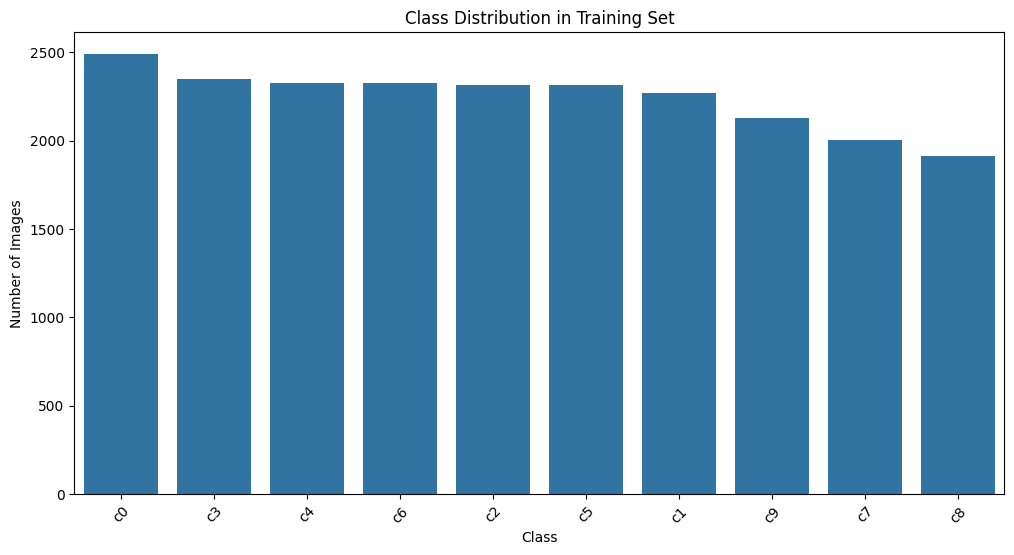


Sample Image Sizes: {(640, 480)}


In [ ]:
# dataset paths
dataset_path = "/content/drive/MyDrive/Koushik/state-farm-distracted-driver-detection"
train_img_dir = os.path.join(dataset_path, "imgs", "train")
test_img_dir = os.path.join(dataset_path, "imgs", "test")

driver_img_list = pd.read_csv(os.path.join(dataset_path, "driver_imgs_list.csv"))
sample_submission = pd.read_csv(os.path.join(dataset_path, "sample_submission.csv"))

# head()
print("Driver Images List:")
print(driver_img_list.head())
print("\nSample Submission:")
print(sample_submission.head())

# distribution
class_distribution = driver_img_list['classname'].value_counts()
print("\nClass Distribution:")
print(class_distribution)

plt.figure(figsize=(12, 6))
sns.barplot(x=class_distribution.index, y=class_distribution.values)
plt.title('Class Distribution in Training Set')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.xticks(rotation=45)
plt.show()

# image sizes
img_sizes = []
for img_file in os.listdir(train_img_dir + "/c0")[:10]:
    img_path = os.path.join(train_img_dir, "c0", img_file)
    img = Image.open(img_path)
    img_sizes.append(img.size)

print("\nSample Image Sizes:", set(img_sizes))

In [ ]:
# for ViT and CNN models
img_size = 224

transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Custom Dataset class
class DriverDataset(Dataset):
    def __init__(self, img_dir, df, transform=None):
        self.img_dir = img_dir
        self.df = df
        self.transform = transform
        self.class_to_idx = {'c0': 0, 'c1': 1, 'c2': 2, 'c3': 3, 'c4': 4,
                           'c5': 5, 'c6': 6, 'c7': 7, 'c8': 8, 'c9': 9}

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_info = self.df.iloc[idx]
        class_name = img_info['classname']
        img_path = os.path.join(self.img_dir, class_name, img_info['img'])

        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        label = self.class_to_idx[class_name]
        return image, label

# train and validation sets
train_df, val_df = train_test_split(driver_img_list, test_size=0.2, stratify=driver_img_list['classname'], random_state=42)

train_dataset = DriverDataset(train_img_dir, train_df, transform=transform)
val_dataset = DriverDataset(train_img_dir, val_df, transform=transform)

# batch
batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")

Training samples: 17939
Validation samples: 4485


In [ ]:
# for SigLIP
img_size = 224

# for CNN and ViT
standard_transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# for SigLIP
siglip_transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor()  # No normalization for SigLIP
])

class HybridModel(nn.Module):
    def __init__(self, num_classes=10):
        super(HybridModel, self).__init__()

        # CNN (ResNet18)
        self.cnn = models.resnet18(pretrained=True)
        self.cnn = nn.Sequential(*list(self.cnn.children())[:-1])

        # ViT
        self.vit = ViTModel.from_pretrained('google/vit-base-patch16-224-in21k')

        # SigLIP
        self.siglip_processor = SiglipImageProcessor.from_pretrained("google/siglip-base-patch16-224")
        self.siglip = SiglipVisionModel.from_pretrained("google/siglip-base-patch16-224")

        # Freeze
        for param in self.cnn.parameters():
            param.requires_grad = False
        for param in self.vit.parameters():
            param.requires_grad = False
        for param in self.siglip.parameters():
            param.requires_grad = False

        # Feature fusion
        self.fc1 = nn.Linear(512 + 768 + 768, 512)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        # CNN
        cnn_features = self.cnn(x)
        cnn_features = cnn_features.view(cnn_features.size(0), -1)

        # ViT
        vit_outputs = self.vit(x)
        vit_features = vit_outputs.last_hidden_state[:, 0, :]

        # SigLIP
        mean = torch.tensor([0.485, 0.456, 0.406], device=x.device).view(1, 3, 1, 1)
        std = torch.tensor([0.229, 0.224, 0.225], device=x.device).view(1, 3, 1, 1)
        unnormalized_x = x * std + mean
        unnormalized_x = torch.clamp(unnormalized_x, 0, 1)

        siglip_inputs = self.siglip_processor(images=unnormalized_x, return_tensors="pt").to(x.device)
        siglip_outputs = self.siglip(**siglip_inputs)
        siglip_features = siglip_outputs.last_hidden_state[:, 0, :]

        combined_features = torch.cat([cnn_features, vit_features, siglip_features], dim=1)

        # Classification head
        x = self.fc1(combined_features)
        x = nn.ReLU()(x)
        x = self.dropout(x)
        x = self.fc2(x)

        return x

In [ ]:
# Update the Dataset class to apply both transforms
class DriverDataset(Dataset):
    def __init__(self, img_dir, df):
        self.img_dir = img_dir
        self.df = df
        self.class_to_idx = {'c0': 0, 'c1': 1, 'c2': 2, 'c3': 3, 'c4': 4,
                           'c5': 5, 'c6': 6, 'c7': 7, 'c8': 8, 'c9': 9}

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_info = self.df.iloc[idx]
        class_name = img_info['classname']
        img_path = os.path.join(self.img_dir, class_name, img_info['img'])

        image = Image.open(img_path).convert('RGB')

        standard_img = standard_transform(image)

        siglip_img = siglip_transform(image)

        label = self.class_to_idx[class_name]
        return standard_img, siglip_img, label

train_dataset = DriverDataset(train_img_dir, train_df)
val_dataset = DriverDataset(train_img_dir, val_df)

def collate_fn(batch):
    standard_imgs = torch.stack([item[0] for item in batch])
    siglip_imgs = torch.stack([item[1] for item in batch])
    labels = torch.tensor([item[2] for item in batch])
    return standard_imgs, siglip_imgs, labels

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,
                         num_workers=2, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False,
                       num_workers=2, collate_fn=collate_fn)

# Update the training and evaluation functions
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=25):
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for standard_imgs, siglip_imgs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
            standard_imgs, siglip_imgs, labels = standard_imgs.to(device), siglip_imgs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(standard_imgs)  # We only need to pass standard_imgs now
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_loss = running_loss / len(train_loader)
        train_acc = correct / total

        # Validation
        val_loss, val_acc, val_precision, val_recall, val_f1 = evaluate_model(model, val_loader, criterion)

        print(f"Epoch {epoch+1}/{num_epochs}")
        print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
        print(f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")
        print(f"Val Precision: {val_precision:.4f} | Val Recall: {val_recall:.4f} | Val F1: {val_f1:.4f}")

    return model

# **Evaluation with Epoch = 10**

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 163MB/s]
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, 

config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/368 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/432 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/813M [00:00<?, ?B/s]

Epoch 1: 100%|██████████| 561/561 [44:27<00:00,  4.75s/it]


Epoch 1/10
Train Loss: 1.5270 | Train Acc: 0.4622
Val Loss: 0.6639 | Val Acc: 0.8531
Val Precision: 0.8606 | Val Recall: 0.8531 | Val F1: 0.8457


Epoch 2: 100%|██████████| 561/561 [03:16<00:00,  2.86it/s]


Epoch 2/10
Train Loss: 0.8058 | Train Acc: 0.7271
Val Loss: 0.4215 | Val Acc: 0.8841
Val Precision: 0.8914 | Val Recall: 0.8841 | Val F1: 0.8816


Epoch 3: 100%|██████████| 561/561 [03:07<00:00,  3.00it/s]


Epoch 3/10
Train Loss: 0.6364 | Train Acc: 0.7825
Val Loss: 0.3057 | Val Acc: 0.9295
Val Precision: 0.9333 | Val Recall: 0.9295 | Val F1: 0.9303


Epoch 4: 100%|██████████| 561/561 [03:10<00:00,  2.94it/s]


Epoch 4/10
Train Loss: 0.5617 | Train Acc: 0.8069
Val Loss: 0.3143 | Val Acc: 0.9313
Val Precision: 0.9350 | Val Recall: 0.9313 | Val F1: 0.9321


Epoch 5: 100%|██████████| 561/561 [03:16<00:00,  2.86it/s]


Epoch 5/10
Train Loss: 0.5482 | Train Acc: 0.8072
Val Loss: 0.1970 | Val Acc: 0.9478
Val Precision: 0.9486 | Val Recall: 0.9478 | Val F1: 0.9475


Epoch 6: 100%|██████████| 561/561 [03:05<00:00,  3.03it/s]


Epoch 6/10
Train Loss: 0.5114 | Train Acc: 0.8185
Val Loss: 0.2209 | Val Acc: 0.9434
Val Precision: 0.9463 | Val Recall: 0.9434 | Val F1: 0.9433


Epoch 7: 100%|██████████| 561/561 [03:08<00:00,  2.98it/s]


Epoch 7/10
Train Loss: 0.4754 | Train Acc: 0.8340
Val Loss: 0.1954 | Val Acc: 0.9538
Val Precision: 0.9553 | Val Recall: 0.9538 | Val F1: 0.9537


Epoch 8: 100%|██████████| 561/561 [03:15<00:00,  2.86it/s]


Epoch 8/10
Train Loss: 0.4636 | Train Acc: 0.8376
Val Loss: 0.1701 | Val Acc: 0.9494
Val Precision: 0.9526 | Val Recall: 0.9494 | Val F1: 0.9499


Epoch 9: 100%|██████████| 561/561 [03:01<00:00,  3.09it/s]


Epoch 9/10
Train Loss: 0.4645 | Train Acc: 0.8338
Val Loss: 0.1607 | Val Acc: 0.9547
Val Precision: 0.9560 | Val Recall: 0.9547 | Val F1: 0.9546


Epoch 10: 100%|██████████| 561/561 [03:05<00:00,  3.02it/s]


Epoch 10/10
Train Loss: 0.4401 | Train Acc: 0.8427
Val Loss: 0.1350 | Val Acc: 0.9628
Val Precision: 0.9631 | Val Recall: 0.9628 | Val F1: 0.9626


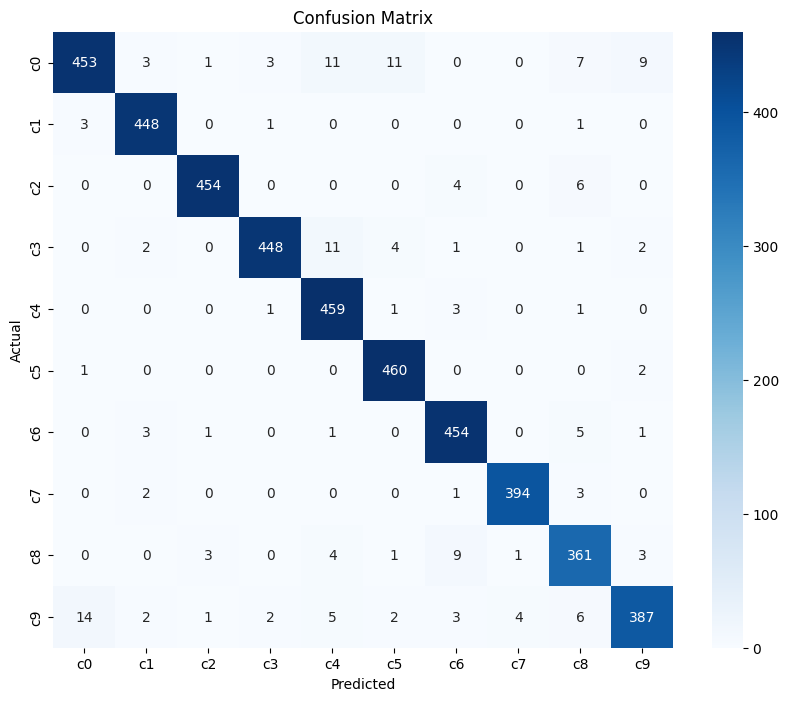

In [ ]:
def evaluate_model(model, data_loader, criterion):
    model.eval()
    running_loss = 0.0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for standard_imgs, siglip_imgs, labels in data_loader:
            standard_imgs, siglip_imgs, labels = standard_imgs.to(device), siglip_imgs.to(device), labels.to(device)
            outputs = model(standard_imgs)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    val_loss = running_loss / len(data_loader)
    val_acc = accuracy_score(all_labels, all_preds)
    val_precision = precision_score(all_labels, all_preds, average='weighted')
    val_recall = recall_score(all_labels, all_preds, average='weighted')
    val_f1 = f1_score(all_labels, all_preds, average='weighted')

    return val_loss, val_acc, val_precision, val_recall, val_f1

# Initialize and train the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = HybridModel(num_classes=10).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

trained_model = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=15)

# Plot confusion matrix
def plot_confusion_matrix(model, data_loader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for standard_imgs, siglip_imgs, labels in data_loader:
            standard_imgs, siglip_imgs, labels = standard_imgs.to(device), siglip_imgs.to(device), labels.to(device)
            outputs = model(standard_imgs)
            _, predicted = torch.max(outputs.data, 1)

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=[f'c{i}' for i in range(10)],
                yticklabels=[f'c{i}' for i in range(10)])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

plot_confusion_matrix(trained_model, val_loader)

# **Evaluation with Epoch =25**

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch 1: 100%|██████████| 561/561 [03:12<00:00,  2.91it/s]


Epoch 1/25
Train Loss: 1.5346 | Train Acc: 0.4632
Val Loss: 0.6748 | Val Acc: 0.8268
Val Precision: 0.8416 | Val Recall: 0.8268 | Val F1: 0.8139


Epoch 2: 100%|██████████| 561/561 [03:00<00:00,  3.12it/s]


Epoch 2/25
Train Loss: 0.8175 | Train Acc: 0.7222
Val Loss: 0.3571 | Val Acc: 0.9264
Val Precision: 0.9268 | Val Recall: 0.9264 | Val F1: 0.9256


Epoch 3: 100%|██████████| 561/561 [03:00<00:00,  3.10it/s]


Epoch 3/25
Train Loss: 0.6522 | Train Acc: 0.7799
Val Loss: 0.2863 | Val Acc: 0.9284
Val Precision: 0.9306 | Val Recall: 0.9284 | Val F1: 0.9270


Epoch 4: 100%|██████████| 561/561 [02:59<00:00,  3.12it/s]


Epoch 4/25
Train Loss: 0.5663 | Train Acc: 0.8050
Val Loss: 0.2391 | Val Acc: 0.9411
Val Precision: 0.9426 | Val Recall: 0.9411 | Val F1: 0.9409


Epoch 5: 100%|██████████| 561/561 [02:59<00:00,  3.12it/s]


Epoch 5/25
Train Loss: 0.5110 | Train Acc: 0.8239
Val Loss: 0.2079 | Val Acc: 0.9414
Val Precision: 0.9443 | Val Recall: 0.9414 | Val F1: 0.9405


Epoch 6: 100%|██████████| 561/561 [03:00<00:00,  3.10it/s]


Epoch 6/25
Train Loss: 0.4634 | Train Acc: 0.8384
Val Loss: 0.1622 | Val Acc: 0.9581
Val Precision: 0.9584 | Val Recall: 0.9581 | Val F1: 0.9580


Epoch 7: 100%|██████████| 561/561 [03:00<00:00,  3.11it/s]


Epoch 7/25
Train Loss: 0.4938 | Train Acc: 0.8283
Val Loss: 0.1869 | Val Acc: 0.9541
Val Precision: 0.9546 | Val Recall: 0.9541 | Val F1: 0.9537


Epoch 8: 100%|██████████| 561/561 [03:00<00:00,  3.10it/s]


Epoch 8/25
Train Loss: 0.4383 | Train Acc: 0.8487
Val Loss: 0.1541 | Val Acc: 0.9507
Val Precision: 0.9523 | Val Recall: 0.9507 | Val F1: 0.9494


Epoch 9: 100%|██████████| 561/561 [03:00<00:00,  3.10it/s]


Epoch 9/25
Train Loss: 0.4069 | Train Acc: 0.8581
Val Loss: 0.1299 | Val Acc: 0.9645
Val Precision: 0.9646 | Val Recall: 0.9645 | Val F1: 0.9644


Epoch 10: 100%|██████████| 561/561 [03:01<00:00,  3.09it/s]


Epoch 10/25
Train Loss: 0.4313 | Train Acc: 0.8493
Val Loss: 0.1363 | Val Acc: 0.9601
Val Precision: 0.9610 | Val Recall: 0.9601 | Val F1: 0.9600


Epoch 11: 100%|██████████| 561/561 [03:00<00:00,  3.11it/s]


Epoch 11/25
Train Loss: 0.3969 | Train Acc: 0.8594
Val Loss: 0.1167 | Val Acc: 0.9663
Val Precision: 0.9674 | Val Recall: 0.9663 | Val F1: 0.9664


Epoch 12: 100%|██████████| 561/561 [03:01<00:00,  3.10it/s]


Epoch 12/25
Train Loss: 0.3815 | Train Acc: 0.8643
Val Loss: 0.1415 | Val Acc: 0.9592
Val Precision: 0.9597 | Val Recall: 0.9592 | Val F1: 0.9591


Epoch 13: 100%|██████████| 561/561 [03:00<00:00,  3.10it/s]


Epoch 13/25
Train Loss: 0.3831 | Train Acc: 0.8611
Val Loss: 0.1380 | Val Acc: 0.9594
Val Precision: 0.9607 | Val Recall: 0.9594 | Val F1: 0.9595


Epoch 14: 100%|██████████| 561/561 [03:00<00:00,  3.11it/s]


Epoch 14/25
Train Loss: 0.4015 | Train Acc: 0.8557
Val Loss: 0.1192 | Val Acc: 0.9645
Val Precision: 0.9656 | Val Recall: 0.9645 | Val F1: 0.9643


Epoch 15: 100%|██████████| 561/561 [03:00<00:00,  3.10it/s]


Epoch 15/25
Train Loss: 0.3745 | Train Acc: 0.8678
Val Loss: 0.0949 | Val Acc: 0.9746
Val Precision: 0.9748 | Val Recall: 0.9746 | Val F1: 0.9745


Epoch 16: 100%|██████████| 561/561 [03:01<00:00,  3.10it/s]


Epoch 16/25
Train Loss: 0.4119 | Train Acc: 0.8498
Val Loss: 0.1083 | Val Acc: 0.9674
Val Precision: 0.9677 | Val Recall: 0.9674 | Val F1: 0.9675


Epoch 17: 100%|██████████| 561/561 [03:00<00:00,  3.11it/s]


Epoch 17/25
Train Loss: 0.4321 | Train Acc: 0.8404
Val Loss: 0.1197 | Val Acc: 0.9637
Val Precision: 0.9640 | Val Recall: 0.9637 | Val F1: 0.9635


Epoch 18: 100%|██████████| 561/561 [03:00<00:00,  3.11it/s]


Epoch 18/25
Train Loss: 0.4069 | Train Acc: 0.8507
Val Loss: 0.1593 | Val Acc: 0.9503
Val Precision: 0.9561 | Val Recall: 0.9503 | Val F1: 0.9507


Epoch 19: 100%|██████████| 561/561 [03:00<00:00,  3.10it/s]


Epoch 19/25
Train Loss: 0.3724 | Train Acc: 0.8648
Val Loss: 0.1179 | Val Acc: 0.9648
Val Precision: 0.9657 | Val Recall: 0.9648 | Val F1: 0.9648


Epoch 20: 100%|██████████| 561/561 [03:00<00:00,  3.11it/s]


Epoch 20/25
Train Loss: 0.3606 | Train Acc: 0.8695
Val Loss: 0.1073 | Val Acc: 0.9679
Val Precision: 0.9682 | Val Recall: 0.9679 | Val F1: 0.9677


Epoch 21: 100%|██████████| 561/561 [03:00<00:00,  3.11it/s]


Epoch 21/25
Train Loss: 0.3438 | Train Acc: 0.8769
Val Loss: 0.1050 | Val Acc: 0.9674
Val Precision: 0.9687 | Val Recall: 0.9674 | Val F1: 0.9674


Epoch 22: 100%|██████████| 561/561 [03:00<00:00,  3.11it/s]


Epoch 22/25
Train Loss: 0.3547 | Train Acc: 0.8712
Val Loss: 0.1008 | Val Acc: 0.9708
Val Precision: 0.9713 | Val Recall: 0.9708 | Val F1: 0.9708


Epoch 23: 100%|██████████| 561/561 [03:00<00:00,  3.12it/s]


Epoch 23/25
Train Loss: 0.3341 | Train Acc: 0.8791
Val Loss: 0.0923 | Val Acc: 0.9750
Val Precision: 0.9753 | Val Recall: 0.9750 | Val F1: 0.9750


Epoch 24: 100%|██████████| 561/561 [03:00<00:00,  3.11it/s]


Epoch 24/25
Train Loss: 0.3557 | Train Acc: 0.8719
Val Loss: 0.0966 | Val Acc: 0.9732
Val Precision: 0.9734 | Val Recall: 0.9732 | Val F1: 0.9733


Epoch 25: 100%|██████████| 561/561 [03:01<00:00,  3.09it/s]


Epoch 25/25
Train Loss: 0.3300 | Train Acc: 0.8764
Val Loss: 0.0873 | Val Acc: 0.9735
Val Precision: 0.9740 | Val Recall: 0.9735 | Val F1: 0.9734


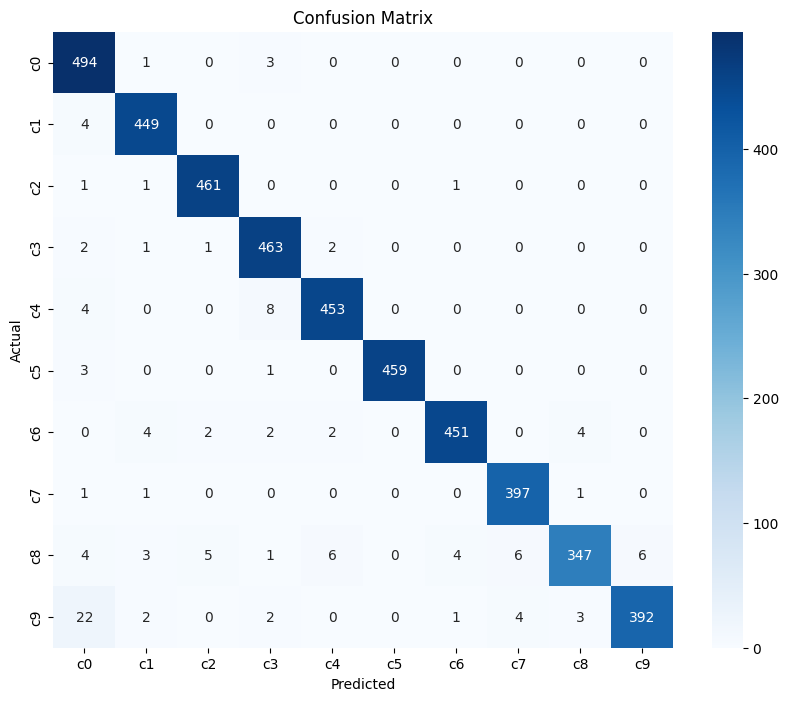

In [ ]:
def evaluate_model(model, data_loader, criterion):
    model.eval()
    running_loss = 0.0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for standard_imgs, siglip_imgs, labels in data_loader:
            standard_imgs, siglip_imgs, labels = standard_imgs.to(device), siglip_imgs.to(device), labels.to(device)
            outputs = model(standard_imgs)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    val_loss = running_loss / len(data_loader)
    val_acc = accuracy_score(all_labels, all_preds)
    val_precision = precision_score(all_labels, all_preds, average='weighted')
    val_recall = recall_score(all_labels, all_preds, average='weighted')
    val_f1 = f1_score(all_labels, all_preds, average='weighted')

    return val_loss, val_acc, val_precision, val_recall, val_f1

# Initialize and train the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = HybridModel(num_classes=10).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

trained_model = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=25)

# Plot confusion matrix
def plot_confusion_matrix(model, data_loader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for standard_imgs, siglip_imgs, labels in data_loader:
            standard_imgs, siglip_imgs, labels = standard_imgs.to(device), siglip_imgs.to(device), labels.to(device)
            outputs = model(standard_imgs)
            _, predicted = torch.max(outputs.data, 1)

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=[f'c{i}' for i in range(10)],
                yticklabels=[f'c{i}' for i in range(10)])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

plot_confusion_matrix(trained_model, val_loader)

In [ ]:
import h5py
import os

save_path = '/content/drive/MyDrive/Koushik'
os.makedirs(save_path, exist_ok=True)  # Create directory if it doesn't exist

# Save model weights to H5 file
h5_filename = os.path.join(save_path, 'driver_distraction_model_weights_.h5')

with h5py.File(h5_filename, 'w') as f:
    for name, param in trained_model.named_parameters():
        f.create_dataset(name, data=param.cpu().detach().numpy())

print(f"Model weights saved to {h5_filename}")

Model weights saved to /content/drive/MyDrive/Koushik/driver_distraction_model_weights_.h5


In [ ]:
pt_filename = os.path.join(save_path, 'driver_distraction_model_.pt')

# Save the entire model (architecture + weights + optimizer state)
torch.save({
    'model_state_dict': trained_model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'model_class': trained_model.__class__.__name__,
    'num_classes': 10,
}, pt_filename)

print(f"Full model saved to {pt_filename}")

Full model saved to /content/drive/MyDrive/Koushik/driver_distraction_model_.pt
